<a href="https://www.kaggle.com/code/wintersbae/playground-s3e22-predict-horse-survival?scriptVersionId=166754589" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Import Libraries and Datasets

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import tensorflow as tf
import tensorflow_addons as tfa
import warnings

warnings.filterwarnings("ignore")

from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.inspection import permutation_importance
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, RepeatedKFold
from tensorflow.keras import backend as K
from xgboost import XGBClassifier

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


/kaggle/input/horse-survival-dataset/horse.csv
/kaggle/input/playground-series-s3e22/sample_submission.csv
/kaggle/input/playground-series-s3e22/train.csv
/kaggle/input/playground-series-s3e22/test.csv


In [2]:
pd.set_option('display.max_columns', None)

In [3]:
train_df = pd.read_csv('/kaggle/input/playground-series-s3e22/train.csv')
train_df

,id,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
0,0,yes,adult,530001,38.1,132.0,24.0,cool,reduced,dark_cyanotic,more_3_sec,depressed,absent,slight,slight,less_1_liter,6.5,decreased,distend_small,57.0,8.5,serosanguious,3.4,yes,2209,0,0,no,died
1,1,yes,adult,533836,37.5,88.0,12.0,cool,normal,pale_cyanotic,more_3_sec,mild_pain,absent,moderate,none,more_1_liter,2.0,absent,distend_small,33.0,64.0,serosanguious,2.0,yes,2208,0,0,no,euthanized
2,2,yes,adult,529812,38.3,120.0,28.0,cool,reduced,pale_pink,less_3_sec,extreme_pain,hypomotile,moderate,slight,none,3.5,NaN,distend_large,37.0,6.4,serosanguious,3.4,yes,5124,0,0,no,lived
3,3,yes,adult,5262541,37.1,72.0,30.0,cold,reduced,pale_pink,more_3_sec,mild_pain,hypomotile,moderate,slight,more_1_liter,2.0,decreased,distend_small,53.0,7.0,cloudy,3.9,yes,2208,0,0,yes,lived
4,4,no,adult,5299629,38.0,52.0,48.0,normal,normal,normal_pink,less_3_sec,alert,hypomotile,none,slight,less_1_liter,7.0,normal,normal,47.0,7.3,cloudy,2.6,no,0,0,0,yes,lived
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1230,1230,yes,adult,535246,38.5,129.0,48.0,cool,reduced,pale_pink,more_3_sec,depressed,absent,moderate,none,more_1_liter,2.0,NaN,distend_large,57.0,66.0,serosanguious,2.0,yes,2206,0,0,no,lived
1231,1231,yes,adult,528570,37.5,60.0,50.0,cool,reduced,pale_cyanotic,less_3_sec,mild_pain,hypomotile,slight,slight,none,3.0,decreased,distend_small,35.0,6.4,serosanguious,3.6,yes,2209,0,0,yes,died
1232,1232,yes,young,529685,37.5,84.0,40.0,normal,reduced,normal_pink,less_3_sec,mild_pain,hypomotile,slight,slight,none,3.0,increased,firm,40.0,5.9,cloudy,7.0,yes,400,0,0,yes,lived
1233,1233,yes,adult,534784,38.1,70.0,16.0,normal,reduced,bright_red,less_3_sec,mild_pain,hypomotile,slight,none,more_1_liter,2.0,absent,distend_small,58.0,74.0,cloudy,2.0,yes,2209,0,0,no,lived


In [4]:
test_df = pd.read_csv('/kaggle/input/playground-series-s3e22/test.csv')
test_df

,id,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data
0,1235,no,adult,534053,38.6,40.0,20.0,normal,normal,normal_pink,less_3_sec,mild_pain,hypomotile,slight,none,none,7.0,normal,distend_small,42.0,7.5,clear,2.3,no,0,0,0,no
1,1236,yes,adult,528469,38.2,112.0,48.0,cool,reduced,bright_pink,more_3_sec,depressed,hypomotile,moderate,slight,none,3.5,decreased,distend_small,44.0,6.0,serosanguious,2.6,no,2208,0,0,yes
2,1237,yes,adult,528178,37.7,66.0,12.0,cool,normal,bright_red,less_3_sec,mild_pain,hypomotile,slight,slight,none,3.0,normal,distend_small,31.5,6.0,cloudy,1.6,yes,2205,0,0,yes
3,1238,no,adult,534784,37.1,88.0,20.0,cool,reduced,pale_cyanotic,less_3_sec,depressed,absent,severe,slight,more_1_liter,2.0,absent,distend_large,75.0,81.0,NaN,1.0,yes,1400,0,0,no
4,1239,yes,adult,529840,38.3,50.0,12.0,NaN,normal,bright_pink,less_3_sec,mild_pain,absent,slight,slight,none,3.0,decreased,distend_small,37.0,6.8,cloudy,2.6,yes,2208,0,0,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
819,2054,no,adult,529461,40.3,114.0,36.0,cool,reduced,normal_pink,more_3_sec,depressed,hypomotile,moderate,NaN,none,7.0,normal,distend_large,57.0,8.1,serosanguious,4.5,yes,3205,0,0,yes
820,2055,yes,adult,535338,37.2,100.0,20.0,cool,reduced,pale_cyanotic,more_3_sec,extreme_pain,absent,moderate,slight,more_1_liter,2.0,absent,distend_small,50.0,66.0,serosanguious,2.0,yes,2209,0,0,no
821,2056,yes,adult,529640,39.2,132.0,12.0,cool,reduced,dark_cyanotic,more_3_sec,depressed,hypomotile,moderate,slight,more_1_liter,6.5,decreased,NaN,53.0,7.6,serosanguious,4.5,yes,2205,0,0,no
822,2057,no,adult,5287179,38.3,54.0,66.0,normal,normal,normal_pink,less_3_sec,mild_pain,hypomotile,none,slight,none,7.0,normal,NaN,49.0,8.6,clear,5.0,no,3111,0,0,yes


In [5]:
ids = train_df.pop('id')

In [6]:
horse_df = pd.read_csv('/kaggle/input/horse-survival-dataset/horse.csv')
horse_df

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,outcome,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data
0,no,adult,530101,38.5,66.0,28.0,cool,reduced,NaN,more_3_sec,extreme_pain,absent,severe,NaN,NaN,NaN,decreased,distend_large,45.0,8.4,NaN,NaN,died,no,11300,0,0,no
1,yes,adult,534817,39.2,88.0,20.0,NaN,NaN,pale_cyanotic,less_3_sec,mild_pain,absent,slight,NaN,NaN,NaN,absent,other,50.0,85.0,cloudy,2.0,euthanized,no,2208,0,0,no
2,no,adult,530334,38.3,40.0,24.0,normal,normal,pale_pink,less_3_sec,mild_pain,hypomotile,none,NaN,NaN,NaN,normal,normal,33.0,6.7,NaN,NaN,lived,no,0,0,0,yes
3,yes,young,5290409,39.1,164.0,84.0,cold,normal,dark_cyanotic,more_3_sec,depressed,absent,severe,none,less_1_liter,5.0,decreased,NaN,48.0,7.2,serosanguious,5.3,died,yes,2208,0,0,yes
4,no,adult,530255,37.3,104.0,35.0,NaN,NaN,dark_cyanotic,more_3_sec,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.0,7.4,NaN,NaN,died,no,4300,0,0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,yes,adult,533886,NaN,120.0,70.0,cold,NaN,pale_cyanotic,more_3_sec,depressed,absent,NaN,NaN,NaN,NaN,NaN,distend_large,55.0,65.0,NaN,NaN,euthanized,no,3205,0,0,no
295,no,adult,527702,37.2,72.0,24.0,cool,increased,pale_cyanotic,more_3_sec,severe_pain,hypomotile,moderate,significant,none,NaN,absent,distend_small,44.0,NaN,serosanguious,3.3,euthanized,yes,2208,0,0,yes
296,yes,adult,529386,37.5,72.0,30.0,cold,reduced,pale_cyanotic,less_3_sec,severe_pain,absent,moderate,slight,none,NaN,decreased,distend_large,60.0,6.8,NaN,NaN,died,yes,3205,0,0,no
297,yes,adult,530612,36.5,100.0,24.0,cool,reduced,pale_pink,less_3_sec,mild_pain,hypomotile,moderate,significant,none,NaN,absent,distend_small,50.0,6.0,serosanguious,3.4,lived,yes,2208,0,0,yes


In [7]:
drop_df = train_df.dropna()
drop_df

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
0,yes,adult,530001,38.1,132.0,24.0,cool,reduced,dark_cyanotic,more_3_sec,depressed,absent,slight,slight,less_1_liter,6.5,decreased,distend_small,57.0,8.5,serosanguious,3.4,yes,2209,0,0,no,died
1,yes,adult,533836,37.5,88.0,12.0,cool,normal,pale_cyanotic,more_3_sec,mild_pain,absent,moderate,none,more_1_liter,2.0,absent,distend_small,33.0,64.0,serosanguious,2.0,yes,2208,0,0,no,euthanized
3,yes,adult,5262541,37.1,72.0,30.0,cold,reduced,pale_pink,more_3_sec,mild_pain,hypomotile,moderate,slight,more_1_liter,2.0,decreased,distend_small,53.0,7.0,cloudy,3.9,yes,2208,0,0,yes,lived
4,no,adult,5299629,38.0,52.0,48.0,normal,normal,normal_pink,less_3_sec,alert,hypomotile,none,slight,less_1_liter,7.0,normal,normal,47.0,7.3,cloudy,2.6,no,0,0,0,yes,lived
5,no,adult,529642,38.1,56.0,32.0,normal,normal,bright_pink,less_3_sec,depressed,hypomotile,none,none,more_1_liter,5.0,decreased,firm,49.0,8.0,cloudy,2.8,no,0,0,0,yes,lived
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1228,yes,adult,534963,38.3,48.0,20.0,normal,normal,bright_pink,more_3_sec,depressed,absent,slight,none,less_1_liter,2.0,decreased,distend_small,41.0,65.0,clear,2.0,yes,3111,0,0,no,lived
1229,yes,adult,535338,38.0,136.0,20.0,cool,reduced,bright_red,less_3_sec,depressed,hypomotile,moderate,slight,more_1_liter,5.0,decreased,distend_small,66.0,65.0,serosanguious,2.0,yes,2208,0,0,no,lived
1231,yes,adult,528570,37.5,60.0,50.0,cool,reduced,pale_cyanotic,less_3_sec,mild_pain,hypomotile,slight,slight,none,3.0,decreased,distend_small,35.0,6.4,serosanguious,3.6,yes,2209,0,0,yes,died
1232,yes,young,529685,37.5,84.0,40.0,normal,reduced,normal_pink,less_3_sec,mild_pain,hypomotile,slight,slight,none,3.0,increased,firm,40.0,5.9,cloudy,7.0,yes,400,0,0,yes,lived


# Check Missing Values

In [8]:
miss_type_df = pd.DataFrame()
miss_type_df['col_name'] = train_df.columns
miss_type_df['train_missing_val'] = train_df.isna().sum().values
test_miss_values = test_df.drop('id', axis=1).isna().sum().values
miss_type_df['test_missing_val'] = np.append(test_miss_values, 0)
miss_type_df['dtypes'] = train_df.dtypes.values
miss_type_df

,col_name,train_missing_val,test_missing_val,dtypes
0,surgery,0,0,object
1,age,0,0,object
2,hospital_number,0,0,int64
3,rectal_temp,0,0,float64
4,pulse,0,0,float64
5,respiratory_rate,0,0,float64
6,temp_of_extremities,39,35,object
7,peripheral_pulse,60,47,object
8,mucous_membrane,21,13,object
9,capillary_refill_time,6,6,object


# Categorical Column Values

In [9]:
num_cols = train_df._get_numeric_data().columns.tolist()
cat_cols = [x for x in train_df.columns if x not in num_cols]

print(num_cols)
print(cat_cols)

print(len(num_cols) + len(cat_cols))

['hospital_number', 'rectal_temp', 'pulse', 'respiratory_rate', 'nasogastric_reflux_ph', 'packed_cell_volume', 'total_protein', 'abdomo_protein', 'lesion_1', 'lesion_2', 'lesion_3']
['surgery', 'age', 'temp_of_extremities', 'peripheral_pulse', 'mucous_membrane', 'capillary_refill_time', 'pain', 'peristalsis', 'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux', 'rectal_exam_feces', 'abdomen', 'abdomo_appearance', 'surgical_lesion', 'cp_data', 'outcome']
28


In [10]:
cat_df = train_df.copy()[cat_cols]
for col, i in zip(cat_df.columns, range(len(cat_df.columns))):
    print(str(i) + '. ' + col + ': ' + ", ".join(cat_df[col].astype(str).unique()))

0. surgery: yes, no
1. age: adult, young
2. temp_of_extremities: cool, cold, normal, warm, nan
3. peripheral_pulse: reduced, normal, nan, absent, increased
4. mucous_membrane: dark_cyanotic, pale_cyanotic, pale_pink, normal_pink, bright_pink, bright_red, nan
5. capillary_refill_time: more_3_sec, less_3_sec, nan, 3
6. pain: depressed, mild_pain, extreme_pain, alert, severe_pain, nan, slight
7. peristalsis: absent, hypomotile, normal, hypermotile, nan, distend_small
8. abdominal_distention: slight, moderate, none, severe, nan
9. nasogastric_tube: slight, none, significant, nan
10. nasogastric_reflux: less_1_liter, more_1_liter, none, nan, slight
11. rectal_exam_feces: decreased, absent, nan, normal, increased, serosanguious
12. abdomen: distend_small, distend_large, normal, firm, nan, other
13. abdomo_appearance: serosanguious, cloudy, clear, nan
14. surgical_lesion: yes, no
15. cp_data: no, yes
16. outcome: died, euthanized, lived


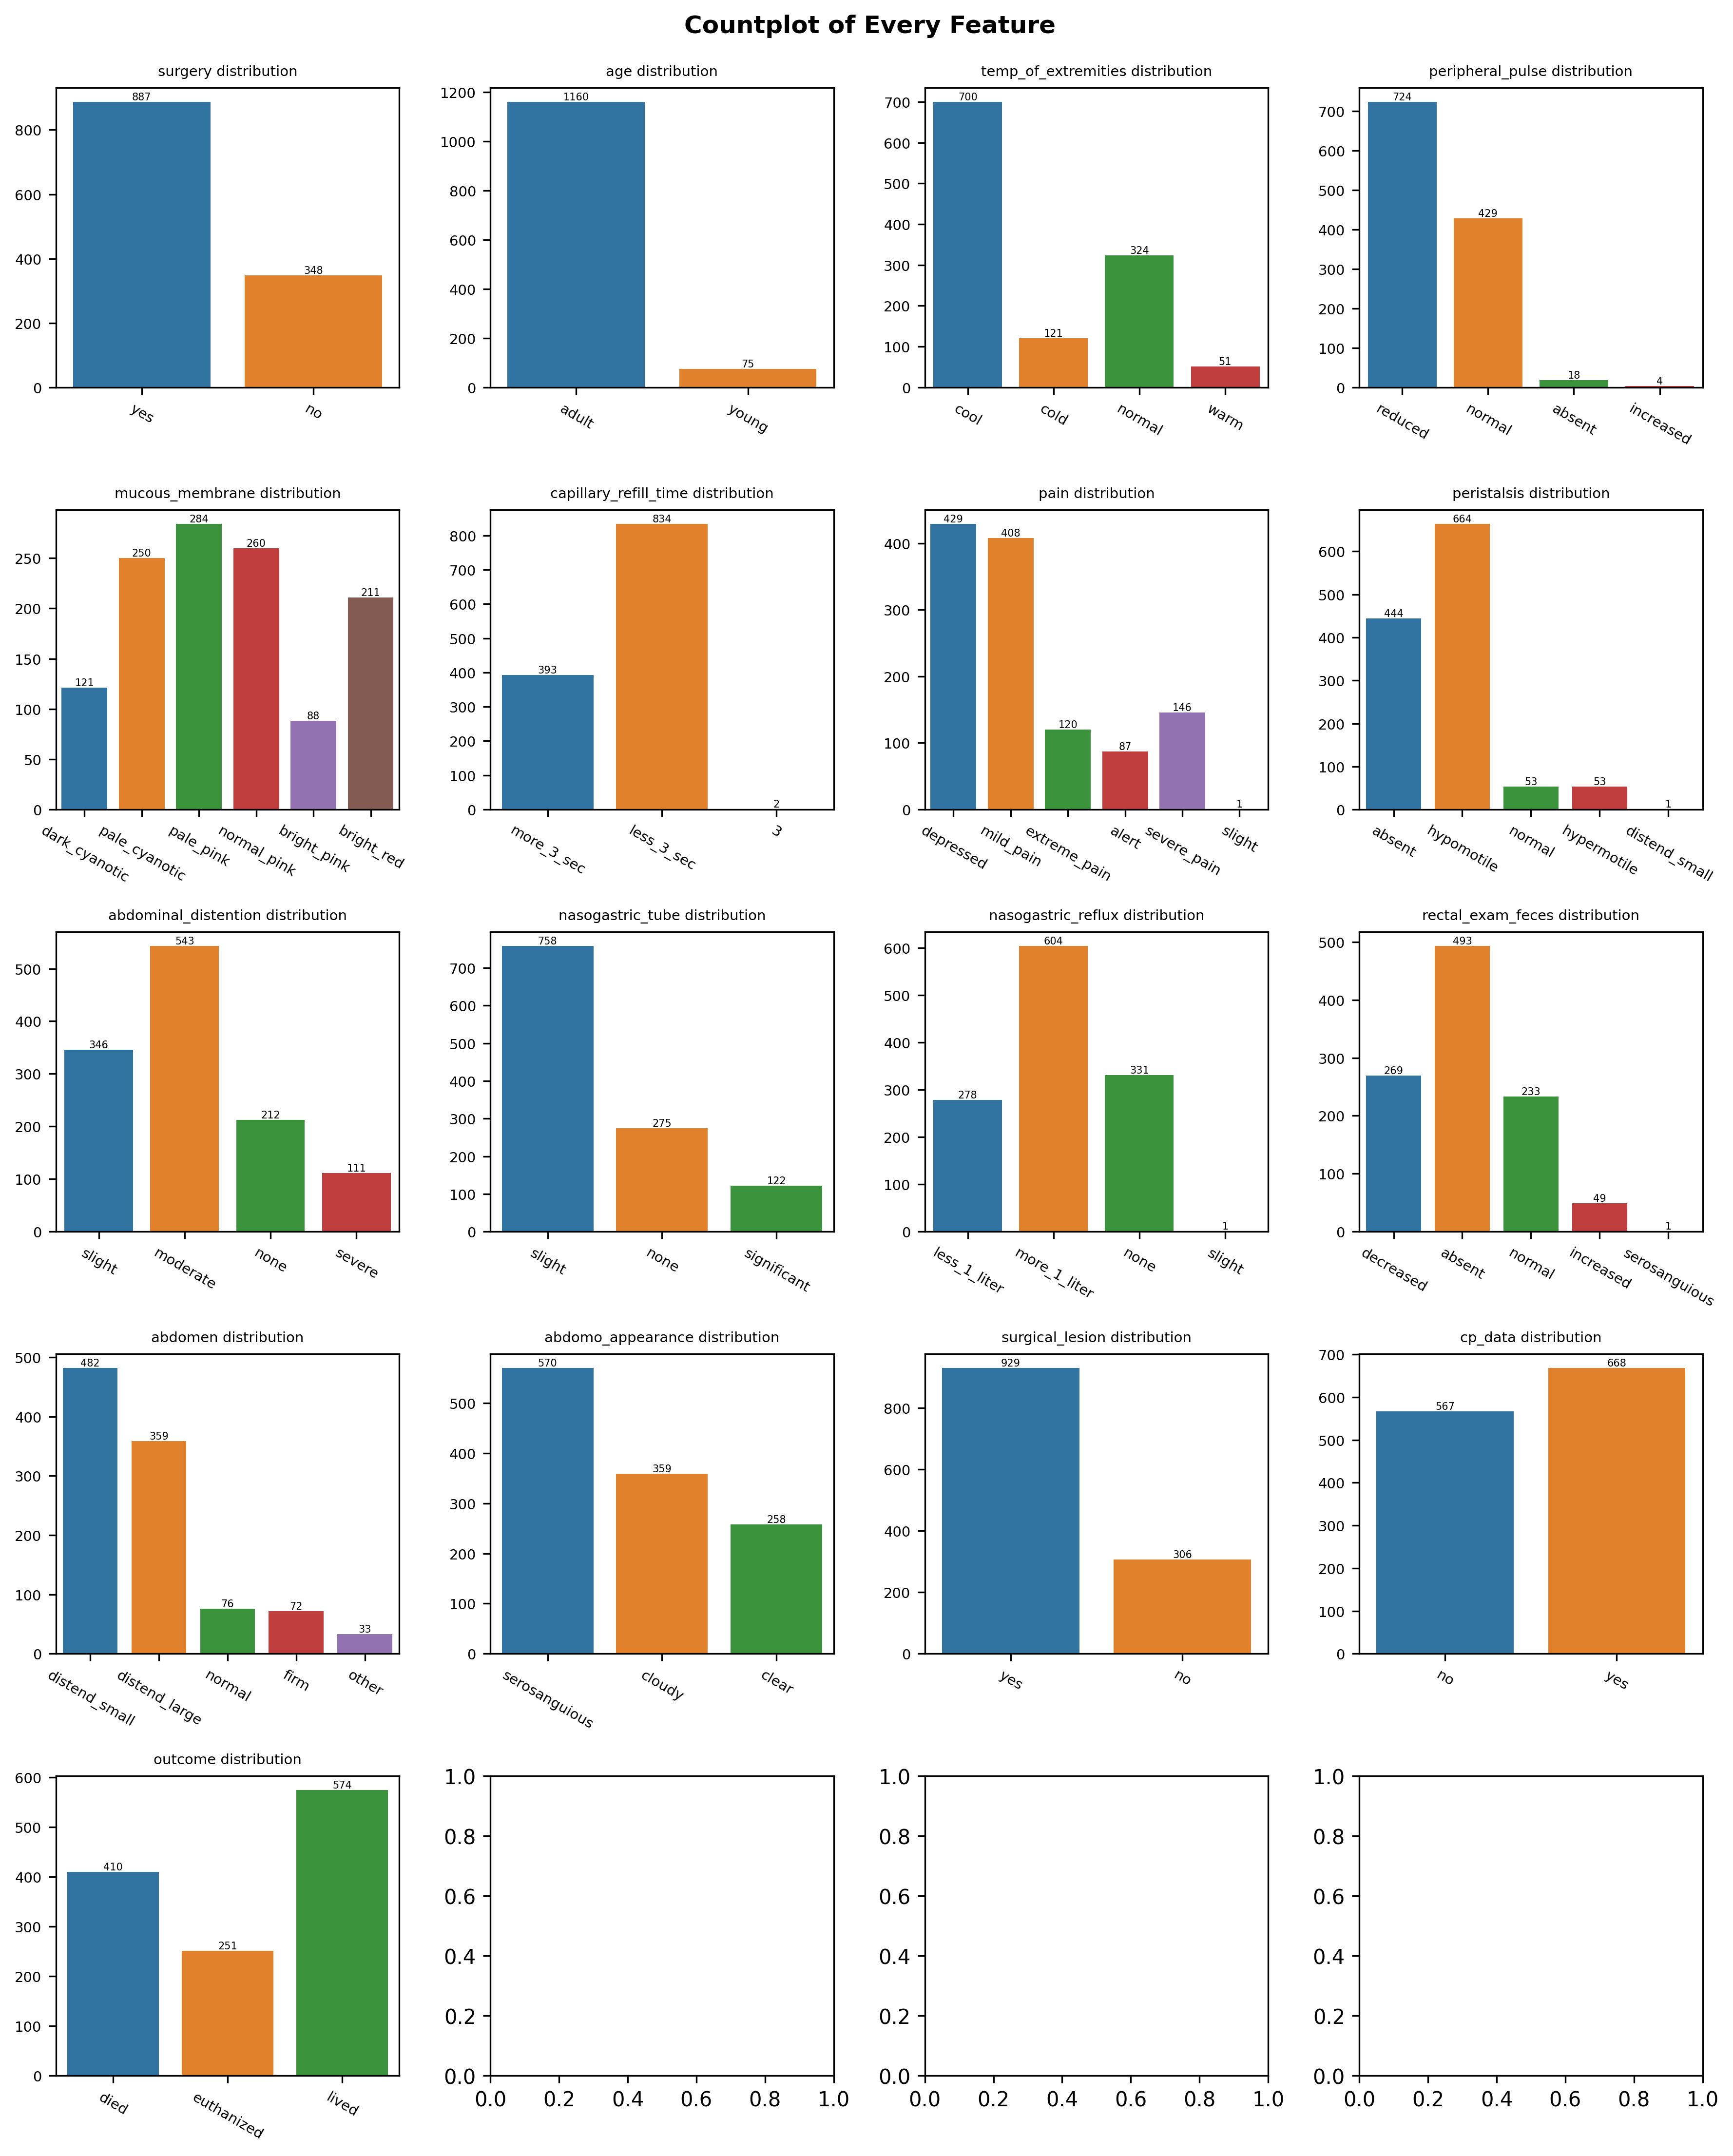

In [11]:
fig, ax = plt.subplots(5, 4, figsize=(12, 15), dpi=300)
ax = ax.flatten()

for i, column in enumerate(list(cat_df.columns)):
    g = sns.countplot(x=column, data=cat_df, ax=ax[i])
    
    ax[i].bar_label(ax[i].containers[0], size=5)
    
    ax[i].set_title(f'{column} distribution', size=7)
    ax[i].set_ylabel(None)
    ax[i].set_xlabel(None)
    
    ax[i].tick_params(labelsize=7,axis='x', rotation=-30)
    ax[i].tick_params(labelsize=7,axis='y')
    
fig.suptitle('Countplot of Every Feature\n', fontsize = 12, fontweight = 'bold')

plt.tight_layout()

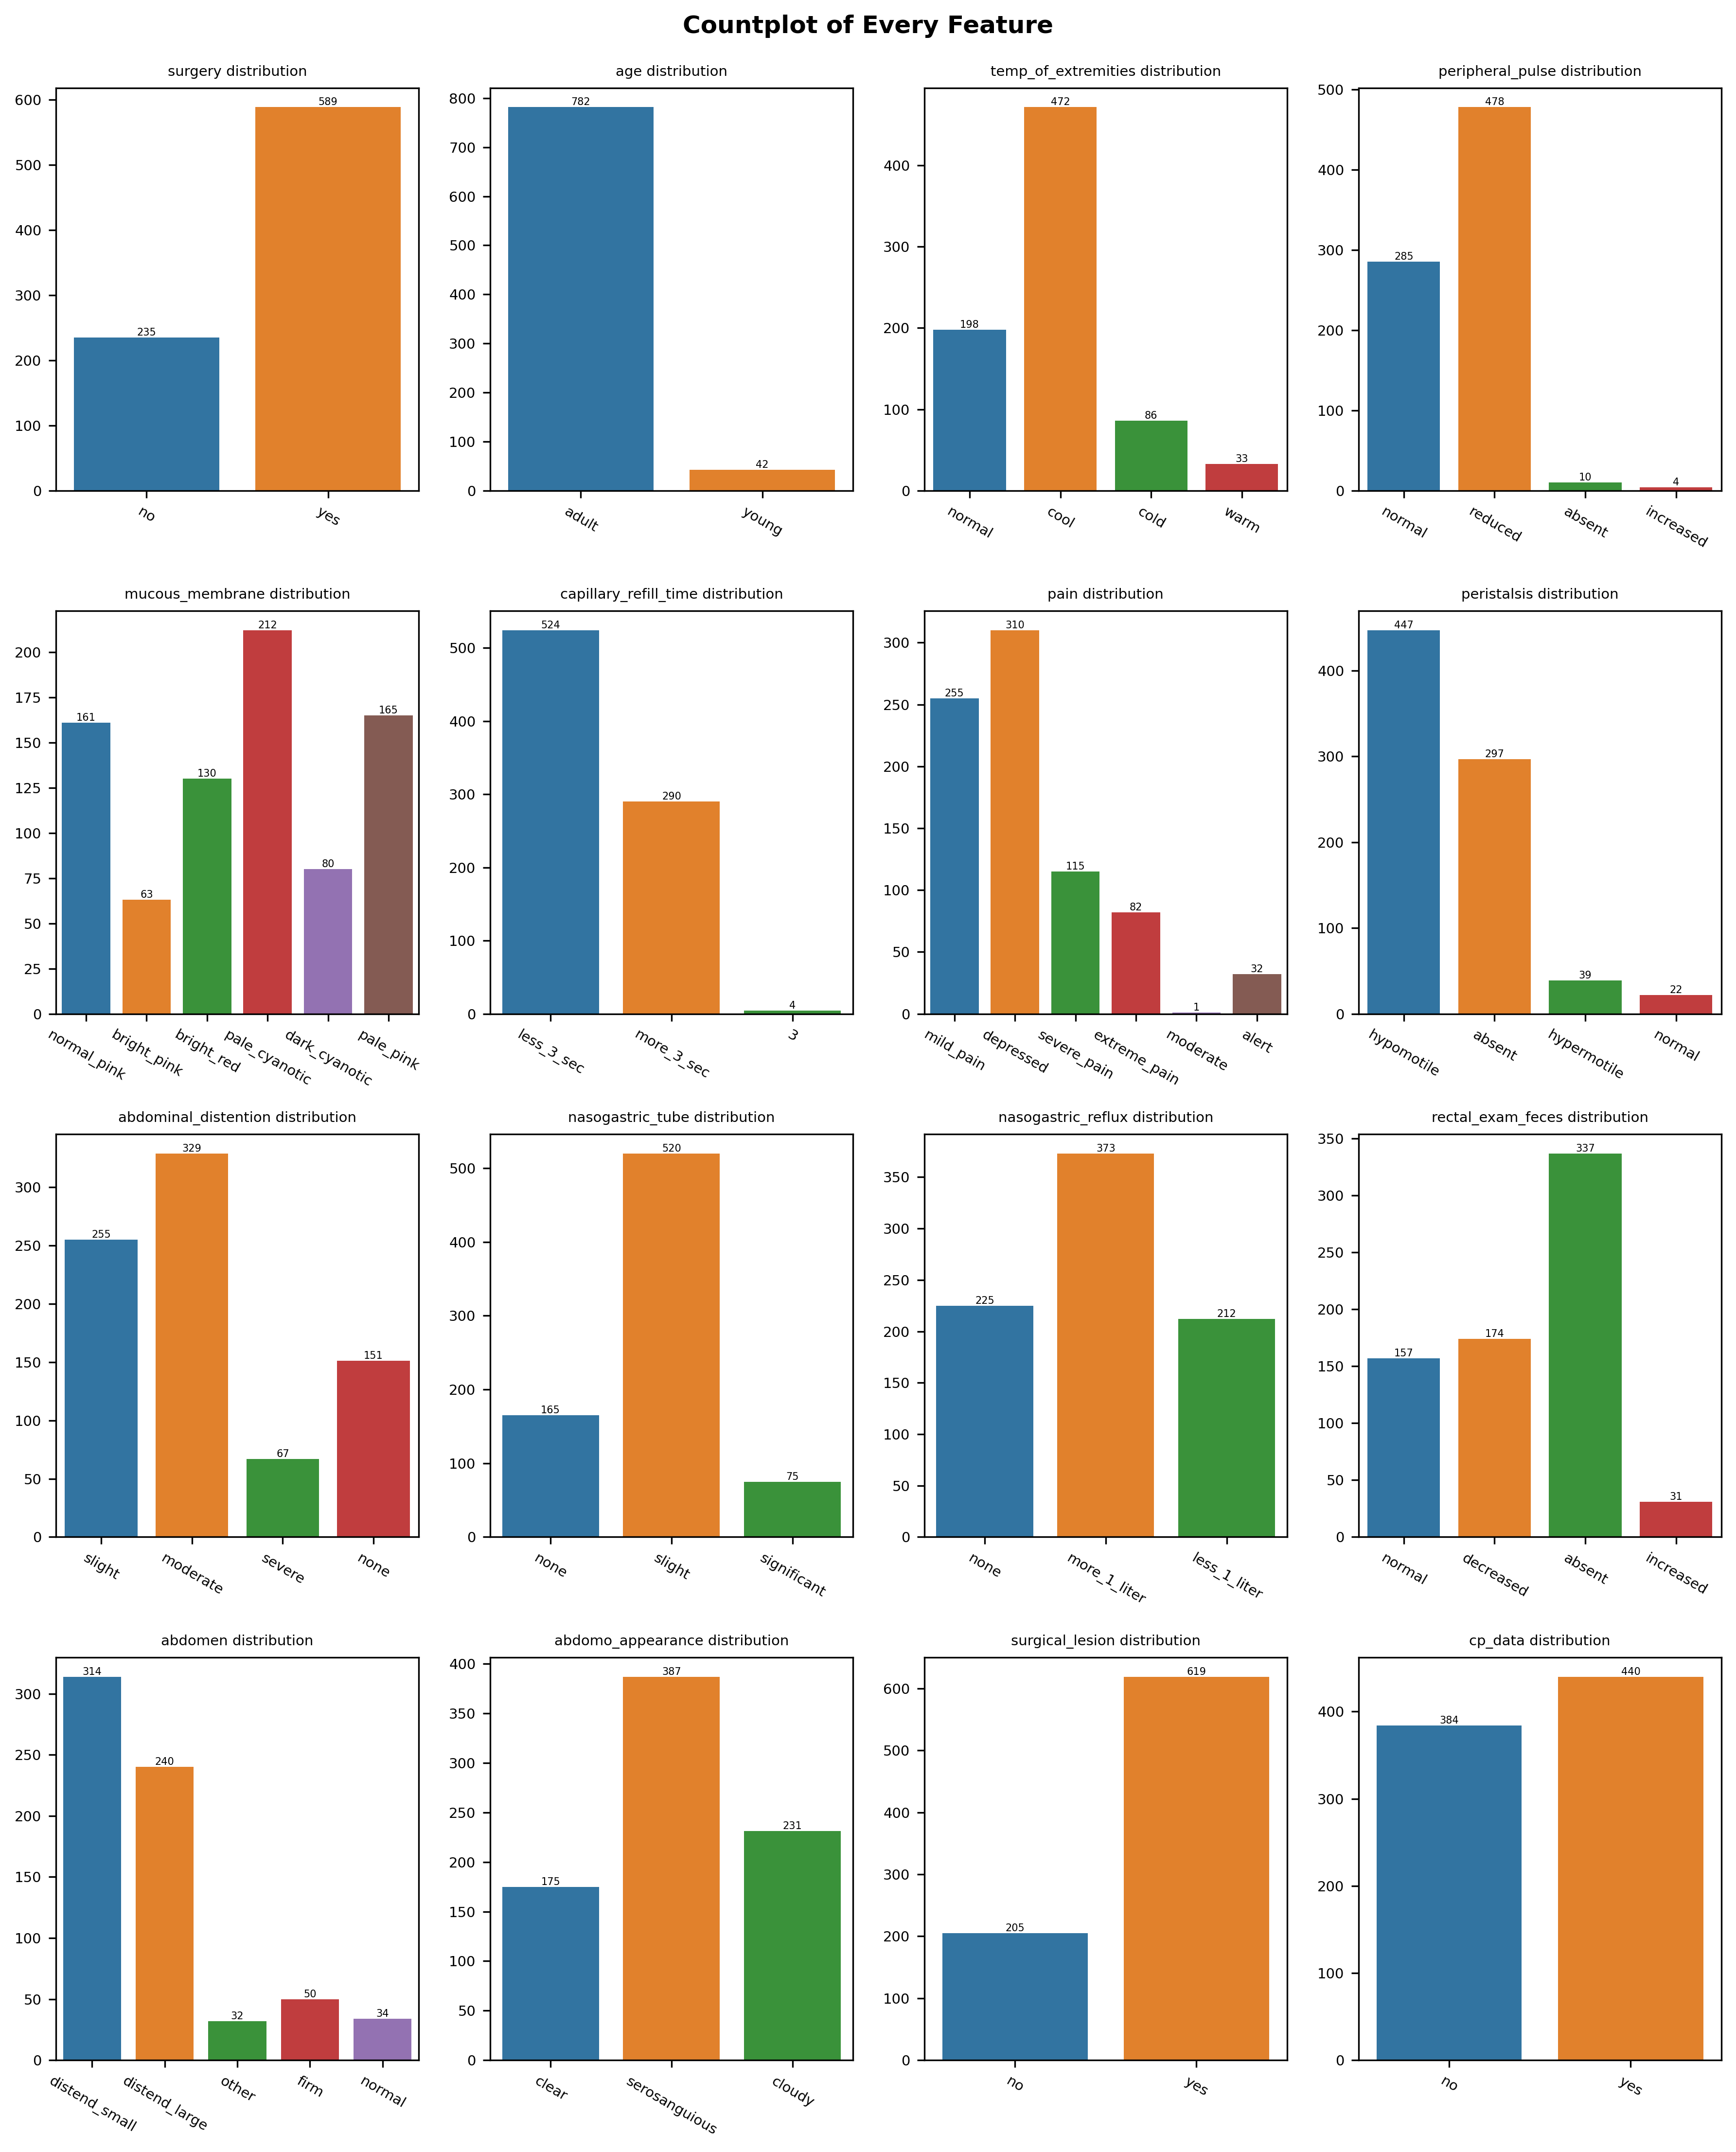

In [12]:
fig, ax = plt.subplots(4, 4, figsize=(12, 15), dpi=300)
ax = ax.flatten()

for i, column in enumerate(list(test_df[cat_cols[:-1]].columns)):
    g = sns.countplot(x=column, data=test_df, ax=ax[i])
    
    ax[i].bar_label(ax[i].containers[0], size=5)
    
    ax[i].set_title(f'{column} distribution', size=7)
    ax[i].set_ylabel(None)
    ax[i].set_xlabel(None)
    
    ax[i].tick_params(labelsize=7,axis='x', rotation=-30)
    ax[i].tick_params(labelsize=7,axis='y')
    
fig.suptitle('Countplot of Every Feature\n', fontsize = 12, fontweight = 'bold')

plt.tight_layout()

* Feature with low value:
    *  peripheral_pulse = ['increased', 4] -> both train and test
    * capillary_refill_time = ['3', 2] ->both train and test
    * pain = ['slight', 1] -> only train
    * pain = ['moderate', 1] -> only test
    * peristalsis = ['distend_small', 1] -> only train
    * nasogastric_reflux = ['slight', 1] -> only train
    * rectal_exam_feces = ['serosanguious', 1] -> only train


* Target class imbalanced

# Remove/Modify Low Frequency Values

In [13]:
drop_cat_df = train_df.copy()

# drop_cat_df = drop_cat_df.drop(drop_cat_df[drop_cat_df['peripheral_pulse'] == 'increased'].index)
drop_cat_df = drop_cat_df.drop(drop_cat_df[drop_cat_df['pain'] == 'slight'].index)
drop_cat_df = drop_cat_df.drop(drop_cat_df[drop_cat_df['peristalsis'] == 'distend_small'].index)
drop_cat_df = drop_cat_df.drop(drop_cat_df[drop_cat_df['nasogastric_reflux'] == 'slight'].index)
drop_cat_df = drop_cat_df.drop(drop_cat_df[drop_cat_df['rectal_exam_feces'] == 'serosanguious'].index)

drop_cat_df = drop_cat_df.replace('3', 'less_3_sec')

drop_cat_df = drop_cat_df.reset_index(drop=True)

In [14]:
test_df['pain'] = test_df['pain'].replace('moderate', 'mild_pain')
test_df = test_df.replace('3', 'less_3_sec')

# Encode Categorical Values

In [15]:
drop_oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
drop_oe.fit(drop_cat_df[cat_cols])
nan = drop_oe.categories_[3][4]
drop_oe.categories_[0] = np.array(['no', 'yes'])
drop_oe.categories_[1] = np.array(['adult', 'young'])
drop_oe.categories_[2] = np.array(['warm', 'normal', 'cool', 'cold', nan])
drop_oe.categories_[3] = np.array(['absent', 'increased', 'normal', 'reduced', nan])
drop_oe.categories_[4] = np.array(['bright_pink', 'bright_red', 'dark_cyanotic', 'normal_pink',
                                   'pale_cyanotic', 'pale_pink', nan])
drop_oe.categories_[5] = np.array(['less_3_sec', 'more_3_sec', nan])
drop_oe.categories_[6] = np.array(['alert', 'depressed', 'severe_pain', 'mild_pain', 'extreme_pain', nan])
drop_oe.categories_[7] = np.array(['absent', 'hypomotile', 'normal', 'hypermotile', nan])
drop_oe.categories_[8] = np.array(['none', 'slight', 'moderate', 'severe', nan])
drop_oe.categories_[9] = np.array(['none', 'slight', 'significant', nan])
drop_oe.categories_[10] = np.array(['none', 'less_1_liter', 'more_1_liter', nan])
drop_oe.categories_[11] = np.array(['increased', 'normal', 'decreased', 'absent', nan])
drop_oe.categories_[12] = np.array(['normal', 'other', 'distend_small', 'distend_large', 'firm', nan])
drop_oe.categories_[13] = np.array(['clear', 'cloudy', 'serosanguious', nan])
drop_oe.categories_[14] = np.array(['no', 'yes'])
drop_oe.categories_[15] = np.array(['no', 'yes'])
drop_oe.categories_[16] = np.array(['died', 'euthanized', 'lived'])

In [16]:
enc_drop_cat = drop_oe.set_params(encoded_missing_value=-1).transform(drop_cat_df[cat_cols])
enc_drop_cat_df = pd.DataFrame(enc_drop_cat, columns=cat_cols)
enc_drop_cat_df

,surgery,age,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,rectal_exam_feces,abdomen,abdomo_appearance,surgical_lesion,cp_data,outcome
0,1.0,0.0,2.0,3.0,2.0,1.0,1.0,0.0,1.0,1.0,1.0,2.0,2.0,2.0,1.0,0.0,0.0
1,1.0,0.0,2.0,2.0,4.0,1.0,3.0,0.0,2.0,0.0,2.0,3.0,2.0,2.0,1.0,0.0,1.0
2,1.0,0.0,2.0,3.0,5.0,0.0,4.0,1.0,2.0,1.0,0.0,-1.0,3.0,2.0,1.0,0.0,2.0
3,1.0,0.0,3.0,3.0,5.0,1.0,3.0,1.0,2.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0,2.0
4,0.0,0.0,1.0,2.0,3.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1226,1.0,0.0,2.0,3.0,5.0,1.0,1.0,0.0,2.0,0.0,2.0,-1.0,3.0,2.0,1.0,0.0,2.0
1227,1.0,0.0,2.0,3.0,4.0,0.0,3.0,1.0,1.0,1.0,0.0,2.0,2.0,2.0,1.0,1.0,0.0
1228,1.0,1.0,1.0,3.0,3.0,0.0,3.0,1.0,1.0,1.0,0.0,0.0,4.0,1.0,1.0,1.0,2.0
1229,1.0,0.0,1.0,3.0,1.0,0.0,3.0,1.0,1.0,0.0,2.0,3.0,2.0,1.0,1.0,0.0,2.0


In [17]:
enc_test_df = test_df.copy()
enc_test_df['outcome'] = np.zeros(enc_test_df.shape[0])
enc_test_df['outcome'] = enc_test_df['outcome'].astype(object)
enc_test = drop_oe.set_params(encoded_missing_value=-1).transform(enc_test_df[cat_cols])
enc_test_df = pd.DataFrame(enc_test, columns=cat_cols).drop('outcome', axis=1)
enc_test_df

,surgery,age,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,rectal_exam_feces,abdomen,abdomo_appearance,surgical_lesion,cp_data
0,0.0,0.0,1.0,2.0,3.0,0.0,3.0,1.0,1.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0
1,1.0,0.0,2.0,3.0,0.0,1.0,1.0,1.0,2.0,1.0,0.0,2.0,2.0,2.0,0.0,1.0
2,1.0,0.0,2.0,2.0,1.0,0.0,3.0,1.0,1.0,1.0,0.0,1.0,2.0,1.0,1.0,1.0
3,0.0,0.0,2.0,3.0,4.0,0.0,1.0,0.0,3.0,1.0,2.0,3.0,3.0,-1.0,1.0,0.0
4,1.0,0.0,-1.0,2.0,0.0,0.0,3.0,0.0,1.0,1.0,0.0,2.0,2.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
819,0.0,0.0,2.0,3.0,3.0,1.0,1.0,1.0,2.0,-1.0,0.0,1.0,3.0,2.0,1.0,1.0
820,1.0,0.0,2.0,3.0,4.0,1.0,4.0,0.0,2.0,1.0,2.0,3.0,2.0,2.0,1.0,0.0
821,1.0,0.0,2.0,3.0,2.0,1.0,1.0,1.0,2.0,1.0,2.0,2.0,-1.0,2.0,1.0,0.0
822,0.0,0.0,1.0,2.0,3.0,0.0,3.0,1.0,0.0,1.0,0.0,1.0,-1.0,0.0,0.0,1.0


In [18]:
for col, i in zip(enc_drop_cat_df.columns, range(len(enc_drop_cat_df.columns))):
    print(str(i) + '. ' + col + ': ' + ", ".join(enc_drop_cat_df[col].astype(str).unique()))

0. surgery: 1.0, 0.0
1. age: 0.0, 1.0
2. temp_of_extremities: 2.0, 3.0, 1.0, 0.0, -1.0
3. peripheral_pulse: 3.0, 2.0, -1.0, 0.0, 1.0
4. mucous_membrane: 2.0, 4.0, 5.0, 3.0, 0.0, 1.0, -1.0
5. capillary_refill_time: 1.0, 0.0, -1.0
6. pain: 1.0, 3.0, 4.0, 0.0, 2.0, -1.0
7. peristalsis: 0.0, 1.0, 2.0, 3.0, -1.0
8. abdominal_distention: 1.0, 2.0, 0.0, 3.0, -1.0
9. nasogastric_tube: 1.0, 0.0, 2.0, -1.0
10. nasogastric_reflux: 1.0, 2.0, 0.0, -1.0
11. rectal_exam_feces: 2.0, 3.0, -1.0, 1.0, 0.0
12. abdomen: 2.0, 3.0, 0.0, 4.0, -1.0, 1.0
13. abdomo_appearance: 2.0, 1.0, 0.0, -1.0
14. surgical_lesion: 1.0, 0.0
15. cp_data: 0.0, 1.0
16. outcome: 0.0, 1.0, 2.0


In [19]:
# oe = OrdinalEncoder()
# oe.fit(cat_df)
# nan = oe.categories_[2][4]
# oe.categories_[2] = ['warm', 'normal', 'cool', 'cold', nan]
# oe.categories_[5] = ['less_3_sec', '3', 'more_3_sec', nan]
# oe.categories_[6] = ['alert', 'depressed', 'slight', 'severe_pain', 'mild_pain', 'extreme_pain', nan]
# oe.categories_[7] = ['absent', 'hypomotile', 'normal', 'distend_small', 'hypermotile', nan]
# oe.categories_[8] = ['none', 'slight', 'moderate', 'severe', nan]
# oe.categories_[9] = ['none', 'slight', 'significant', nan]
# oe.categories_[10] = ['none', 'slight', 'less_1_liter', 'more_1_liter', nan]
# oe.categories_[11] = ['increased', 'normal', 'decreased', 'absent', 'serosanguious', nan]
# oe.categories_[12] = ['normal', 'other', 'distend_small', 'distend_large', 'firm', nan]
# oe.categories_[13] = ['clear', 'cloudy', 'serosanguious', nan]

In [20]:
# enc_cat_df = oe.set_params(encoded_missing_value=-1).transform(cat_df)
# enc_cat_df = pd.DataFrame(enc_cat_df, columns=cat_df.columns)
# enc_cat_df

In [21]:
# for col, i in zip(enc_cat_df.columns, range(len(enc_cat_df.columns))):
#     print(str(i) + '. ' + col + ': ' + ", ".join(enc_cat_df[col].astype(str).unique()))

# Preparation

In [22]:
new_df = drop_cat_df.copy()
new_df[cat_cols] = enc_drop_cat_df
new_df

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
0,1.0,0.0,530001,38.1,132.0,24.0,2.0,3.0,2.0,1.0,1.0,0.0,1.0,1.0,1.0,6.5,2.0,2.0,57.0,8.5,2.0,3.4,1.0,2209,0,0,0.0,0.0
1,1.0,0.0,533836,37.5,88.0,12.0,2.0,2.0,4.0,1.0,3.0,0.0,2.0,0.0,2.0,2.0,3.0,2.0,33.0,64.0,2.0,2.0,1.0,2208,0,0,0.0,1.0
2,1.0,0.0,529812,38.3,120.0,28.0,2.0,3.0,5.0,0.0,4.0,1.0,2.0,1.0,0.0,3.5,-1.0,3.0,37.0,6.4,2.0,3.4,1.0,5124,0,0,0.0,2.0
3,1.0,0.0,5262541,37.1,72.0,30.0,3.0,3.0,5.0,1.0,3.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,53.0,7.0,1.0,3.9,1.0,2208,0,0,1.0,2.0
4,0.0,0.0,5299629,38.0,52.0,48.0,1.0,2.0,3.0,0.0,0.0,1.0,0.0,1.0,1.0,7.0,1.0,0.0,47.0,7.3,1.0,2.6,0.0,0,0,0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1226,1.0,0.0,535246,38.5,129.0,48.0,2.0,3.0,5.0,1.0,1.0,0.0,2.0,0.0,2.0,2.0,-1.0,3.0,57.0,66.0,2.0,2.0,1.0,2206,0,0,0.0,2.0
1227,1.0,0.0,528570,37.5,60.0,50.0,2.0,3.0,4.0,0.0,3.0,1.0,1.0,1.0,0.0,3.0,2.0,2.0,35.0,6.4,2.0,3.6,1.0,2209,0,0,1.0,0.0
1228,1.0,1.0,529685,37.5,84.0,40.0,1.0,3.0,3.0,0.0,3.0,1.0,1.0,1.0,0.0,3.0,0.0,4.0,40.0,5.9,1.0,7.0,1.0,400,0,0,1.0,2.0
1229,1.0,0.0,534784,38.1,70.0,16.0,1.0,3.0,1.0,0.0,3.0,1.0,1.0,0.0,2.0,2.0,3.0,2.0,58.0,74.0,1.0,2.0,1.0,2209,0,0,0.0,2.0


In [23]:
new_test_df = test_df.copy()
new_test_df[cat_cols[:-1]] = enc_test_df
new_test_df

,id,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data
0,1235,0.0,0.0,534053,38.6,40.0,20.0,1.0,2.0,3.0,0.0,3.0,1.0,1.0,0.0,0.0,7.0,1.0,2.0,42.0,7.5,0.0,2.3,0.0,0,0,0,0.0
1,1236,1.0,0.0,528469,38.2,112.0,48.0,2.0,3.0,0.0,1.0,1.0,1.0,2.0,1.0,0.0,3.5,2.0,2.0,44.0,6.0,2.0,2.6,0.0,2208,0,0,1.0
2,1237,1.0,0.0,528178,37.7,66.0,12.0,2.0,2.0,1.0,0.0,3.0,1.0,1.0,1.0,0.0,3.0,1.0,2.0,31.5,6.0,1.0,1.6,1.0,2205,0,0,1.0
3,1238,0.0,0.0,534784,37.1,88.0,20.0,2.0,3.0,4.0,0.0,1.0,0.0,3.0,1.0,2.0,2.0,3.0,3.0,75.0,81.0,-1.0,1.0,1.0,1400,0,0,0.0
4,1239,1.0,0.0,529840,38.3,50.0,12.0,-1.0,2.0,0.0,0.0,3.0,0.0,1.0,1.0,0.0,3.0,2.0,2.0,37.0,6.8,1.0,2.6,1.0,2208,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
819,2054,0.0,0.0,529461,40.3,114.0,36.0,2.0,3.0,3.0,1.0,1.0,1.0,2.0,-1.0,0.0,7.0,1.0,3.0,57.0,8.1,2.0,4.5,1.0,3205,0,0,1.0
820,2055,1.0,0.0,535338,37.2,100.0,20.0,2.0,3.0,4.0,1.0,4.0,0.0,2.0,1.0,2.0,2.0,3.0,2.0,50.0,66.0,2.0,2.0,1.0,2209,0,0,0.0
821,2056,1.0,0.0,529640,39.2,132.0,12.0,2.0,3.0,2.0,1.0,1.0,1.0,2.0,1.0,2.0,6.5,2.0,-1.0,53.0,7.6,2.0,4.5,1.0,2205,0,0,0.0
822,2057,0.0,0.0,5287179,38.3,54.0,66.0,1.0,2.0,3.0,0.0,3.0,1.0,0.0,1.0,0.0,7.0,1.0,-1.0,49.0,8.6,0.0,5.0,0.0,3111,0,0,1.0


In [24]:
hosp_counts = new_df['hospital_number'].value_counts()
new_df['hospital_count'] = new_df.apply(lambda x: hosp_counts[x['hospital_number']], axis=1)
new_df

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome,hospital_count
0,1.0,0.0,530001,38.1,132.0,24.0,2.0,3.0,2.0,1.0,1.0,0.0,1.0,1.0,1.0,6.5,2.0,2.0,57.0,8.5,2.0,3.4,1.0,2209,0,0,0.0,0.0,15
1,1.0,0.0,533836,37.5,88.0,12.0,2.0,2.0,4.0,1.0,3.0,0.0,2.0,0.0,2.0,2.0,3.0,2.0,33.0,64.0,2.0,2.0,1.0,2208,0,0,0.0,1.0,9
2,1.0,0.0,529812,38.3,120.0,28.0,2.0,3.0,5.0,0.0,4.0,1.0,2.0,1.0,0.0,3.5,-1.0,3.0,37.0,6.4,2.0,3.4,1.0,5124,0,0,0.0,2.0,1
3,1.0,0.0,5262541,37.1,72.0,30.0,3.0,3.0,5.0,1.0,3.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,53.0,7.0,1.0,3.9,1.0,2208,0,0,1.0,2.0,2
4,0.0,0.0,5299629,38.0,52.0,48.0,1.0,2.0,3.0,0.0,0.0,1.0,0.0,1.0,1.0,7.0,1.0,0.0,47.0,7.3,1.0,2.6,0.0,0,0,0,1.0,2.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1226,1.0,0.0,535246,38.5,129.0,48.0,2.0,3.0,5.0,1.0,1.0,0.0,2.0,0.0,2.0,2.0,-1.0,3.0,57.0,66.0,2.0,2.0,1.0,2206,0,0,0.0,2.0,2
1227,1.0,0.0,528570,37.5,60.0,50.0,2.0,3.0,4.0,0.0,3.0,1.0,1.0,1.0,0.0,3.0,2.0,2.0,35.0,6.4,2.0,3.6,1.0,2209,0,0,1.0,0.0,16
1228,1.0,1.0,529685,37.5,84.0,40.0,1.0,3.0,3.0,0.0,3.0,1.0,1.0,1.0,0.0,3.0,0.0,4.0,40.0,5.9,1.0,7.0,1.0,400,0,0,1.0,2.0,6
1229,1.0,0.0,534784,38.1,70.0,16.0,1.0,3.0,1.0,0.0,3.0,1.0,1.0,0.0,2.0,2.0,3.0,2.0,58.0,74.0,1.0,2.0,1.0,2209,0,0,0.0,2.0,11


In [25]:
test_hosp_counts = new_test_df['hospital_number'].value_counts()
new_test_df['hospital_count'] = new_test_df.apply(lambda x: test_hosp_counts[x['hospital_number']], axis=1)
new_test_df

,id,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,hospital_count
0,1235,0.0,0.0,534053,38.6,40.0,20.0,1.0,2.0,3.0,0.0,3.0,1.0,1.0,0.0,0.0,7.0,1.0,2.0,42.0,7.5,0.0,2.3,0.0,0,0,0,0.0,1
1,1236,1.0,0.0,528469,38.2,112.0,48.0,2.0,3.0,0.0,1.0,1.0,1.0,2.0,1.0,0.0,3.5,2.0,2.0,44.0,6.0,2.0,2.6,0.0,2208,0,0,1.0,22
2,1237,1.0,0.0,528178,37.7,66.0,12.0,2.0,2.0,1.0,0.0,3.0,1.0,1.0,1.0,0.0,3.0,1.0,2.0,31.5,6.0,1.0,1.6,1.0,2205,0,0,1.0,4
3,1238,0.0,0.0,534784,37.1,88.0,20.0,2.0,3.0,4.0,0.0,1.0,0.0,3.0,1.0,2.0,2.0,3.0,3.0,75.0,81.0,-1.0,1.0,1.0,1400,0,0,0.0,10
4,1239,1.0,0.0,529840,38.3,50.0,12.0,-1.0,2.0,0.0,0.0,3.0,0.0,1.0,1.0,0.0,3.0,2.0,2.0,37.0,6.8,1.0,2.6,1.0,2208,0,0,1.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
819,2054,0.0,0.0,529461,40.3,114.0,36.0,2.0,3.0,3.0,1.0,1.0,1.0,2.0,-1.0,0.0,7.0,1.0,3.0,57.0,8.1,2.0,4.5,1.0,3205,0,0,1.0,35
820,2055,1.0,0.0,535338,37.2,100.0,20.0,2.0,3.0,4.0,1.0,4.0,0.0,2.0,1.0,2.0,2.0,3.0,2.0,50.0,66.0,2.0,2.0,1.0,2209,0,0,0.0,5
821,2056,1.0,0.0,529640,39.2,132.0,12.0,2.0,3.0,2.0,1.0,1.0,1.0,2.0,1.0,2.0,6.5,2.0,-1.0,53.0,7.6,2.0,4.5,1.0,2205,0,0,0.0,2
822,2057,0.0,0.0,5287179,38.3,54.0,66.0,1.0,2.0,3.0,0.0,3.0,1.0,0.0,1.0,0.0,7.0,1.0,-1.0,49.0,8.6,0.0,5.0,0.0,3111,0,0,1.0,18


In [26]:
mm_train_df = pd.get_dummies(new_df.mucous_membrane, dtype=float, prefix='mucous_membrane')
new_df = new_df.join(mm_train_df)
new_df

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome,hospital_count,mucous_membrane_-1.0,mucous_membrane_0.0,mucous_membrane_1.0,mucous_membrane_2.0,mucous_membrane_3.0,mucous_membrane_4.0,mucous_membrane_5.0
0,1.0,0.0,530001,38.1,132.0,24.0,2.0,3.0,2.0,1.0,1.0,0.0,1.0,1.0,1.0,6.5,2.0,2.0,57.0,8.5,2.0,3.4,1.0,2209,0,0,0.0,0.0,15,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.0,533836,37.5,88.0,12.0,2.0,2.0,4.0,1.0,3.0,0.0,2.0,0.0,2.0,2.0,3.0,2.0,33.0,64.0,2.0,2.0,1.0,2208,0,0,0.0,1.0,9,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,529812,38.3,120.0,28.0,2.0,3.0,5.0,0.0,4.0,1.0,2.0,1.0,0.0,3.5,-1.0,3.0,37.0,6.4,2.0,3.4,1.0,5124,0,0,0.0,2.0,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,5262541,37.1,72.0,30.0,3.0,3.0,5.0,1.0,3.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,53.0,7.0,1.0,3.9,1.0,2208,0,0,1.0,2.0,2,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,5299629,38.0,52.0,48.0,1.0,2.0,3.0,0.0,0.0,1.0,0.0,1.0,1.0,7.0,1.0,0.0,47.0,7.3,1.0,2.6,0.0,0,0,0,1.0,2.0,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1226,1.0,0.0,535246,38.5,129.0,48.0,2.0,3.0,5.0,1.0,1.0,0.0,2.0,0.0,2.0,2.0,-1.0,3.0,57.0,66.0,2.0,2.0,1.0,2206,0,0,0.0,2.0,2,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1227,1.0,0.0,528570,37.5,60.0,50.0,2.0,3.0,4.0,0.0,3.0,1.0,1.0,1.0,0.0,3.0,2.0,2.0,35.0,6.4,2.0,3.6,1.0,2209,0,0,1.0,0.0,16,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1228,1.0,1.0,529685,37.5,84.0,40.0,1.0,3.0,3.0,0.0,3.0,1.0,1.0,1.0,0.0,3.0,0.0,4.0,40.0,5.9,1.0,7.0,1.0,400,0,0,1.0,2.0,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1229,1.0,0.0,534784,38.1,70.0,16.0,1.0,3.0,1.0,0.0,3.0,1.0,1.0,0.0,2.0,2.0,3.0,2.0,58.0,74.0,1.0,2.0,1.0,2209,0,0,0.0,2.0,11,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [27]:
mm_test_df = pd.get_dummies(new_test_df.mucous_membrane, dtype=float, prefix='mucous_membrane')
new_test_df = new_test_df.join(mm_test_df)
new_test_df

,id,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,hospital_count,mucous_membrane_-1.0,mucous_membrane_0.0,mucous_membrane_1.0,mucous_membrane_2.0,mucous_membrane_3.0,mucous_membrane_4.0,mucous_membrane_5.0
0,1235,0.0,0.0,534053,38.6,40.0,20.0,1.0,2.0,3.0,0.0,3.0,1.0,1.0,0.0,0.0,7.0,1.0,2.0,42.0,7.5,0.0,2.3,0.0,0,0,0,0.0,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1236,1.0,0.0,528469,38.2,112.0,48.0,2.0,3.0,0.0,1.0,1.0,1.0,2.0,1.0,0.0,3.5,2.0,2.0,44.0,6.0,2.0,2.6,0.0,2208,0,0,1.0,22,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1237,1.0,0.0,528178,37.7,66.0,12.0,2.0,2.0,1.0,0.0,3.0,1.0,1.0,1.0,0.0,3.0,1.0,2.0,31.5,6.0,1.0,1.6,1.0,2205,0,0,1.0,4,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1238,0.0,0.0,534784,37.1,88.0,20.0,2.0,3.0,4.0,0.0,1.0,0.0,3.0,1.0,2.0,2.0,3.0,3.0,75.0,81.0,-1.0,1.0,1.0,1400,0,0,0.0,10,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1239,1.0,0.0,529840,38.3,50.0,12.0,-1.0,2.0,0.0,0.0,3.0,0.0,1.0,1.0,0.0,3.0,2.0,2.0,37.0,6.8,1.0,2.6,1.0,2208,0,0,1.0,4,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
819,2054,0.0,0.0,529461,40.3,114.0,36.0,2.0,3.0,3.0,1.0,1.0,1.0,2.0,-1.0,0.0,7.0,1.0,3.0,57.0,8.1,2.0,4.5,1.0,3205,0,0,1.0,35,0.0,0.0,0.0,0.0,1.0,0.0,0.0
820,2055,1.0,0.0,535338,37.2,100.0,20.0,2.0,3.0,4.0,1.0,4.0,0.0,2.0,1.0,2.0,2.0,3.0,2.0,50.0,66.0,2.0,2.0,1.0,2209,0,0,0.0,5,0.0,0.0,0.0,0.0,0.0,1.0,0.0
821,2056,1.0,0.0,529640,39.2,132.0,12.0,2.0,3.0,2.0,1.0,1.0,1.0,2.0,1.0,2.0,6.5,2.0,-1.0,53.0,7.6,2.0,4.5,1.0,2205,0,0,0.0,2,0.0,0.0,0.0,1.0,0.0,0.0,0.0
822,2057,0.0,0.0,5287179,38.3,54.0,66.0,1.0,2.0,3.0,0.0,3.0,1.0,0.0,1.0,0.0,7.0,1.0,-1.0,49.0,8.6,0.0,5.0,0.0,3111,0,0,1.0,18,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [28]:
print(new_df['lesion_2'].value_counts())
print()
print(new_test_df['lesion_2'].value_counts())

lesion_2
0       1223
1400       4
3111       2
3112       2
Name: count, dtype: int64

lesion_2
0       820
1400      2
3111      1
4300      1
Name: count, dtype: int64


In [29]:
print(new_df['lesion_3'].value_counts())
print()
print(new_test_df['lesion_3'].value_counts())

lesion_3
0       1229
2209       2
Name: count, dtype: int64

lesion_3
0    824
Name: count, dtype: int64


In [30]:
new_df.loc[new_df['lesion_3'] != 0]

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome,hospital_count,mucous_membrane_-1.0,mucous_membrane_0.0,mucous_membrane_1.0,mucous_membrane_2.0,mucous_membrane_3.0,mucous_membrane_4.0,mucous_membrane_5.0
58,1.0,0.0,533887,38.2,88.0,24.0,2.0,3.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,2.0,3.0,3.0,66.0,64.0,2.0,2.0,1.0,4205,3111,2209,0.0,1.0,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0
702,1.0,0.0,528461,38.0,112.0,44.0,2.0,3.0,4.0,0.0,3.0,0.0,2.0,1.0,1.0,4.4,2.0,3.0,60.0,6.1,1.0,2.8,1.0,4205,3111,2209,1.0,2.0,9,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [31]:
new_df.drop(new_df.loc[new_df['lesion_3'] != 0].index, inplace=True)
new_df.drop(['hospital_number', 'lesion_3', 'mucous_membrane'], axis=1, inplace=True)
new_test_df.drop(['hospital_number', 'lesion_3', 'mucous_membrane'], axis=1, inplace=True)
test_ids = new_test_df.pop('id')

In [32]:
new_df

,surgery,age,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,cp_data,outcome,hospital_count,mucous_membrane_-1.0,mucous_membrane_0.0,mucous_membrane_1.0,mucous_membrane_2.0,mucous_membrane_3.0,mucous_membrane_4.0,mucous_membrane_5.0
0,1.0,0.0,38.1,132.0,24.0,2.0,3.0,1.0,1.0,0.0,1.0,1.0,1.0,6.5,2.0,2.0,57.0,8.5,2.0,3.4,1.0,2209,0,0.0,0.0,15,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.0,37.5,88.0,12.0,2.0,2.0,1.0,3.0,0.0,2.0,0.0,2.0,2.0,3.0,2.0,33.0,64.0,2.0,2.0,1.0,2208,0,0.0,1.0,9,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,38.3,120.0,28.0,2.0,3.0,0.0,4.0,1.0,2.0,1.0,0.0,3.5,-1.0,3.0,37.0,6.4,2.0,3.4,1.0,5124,0,0.0,2.0,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,37.1,72.0,30.0,3.0,3.0,1.0,3.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,53.0,7.0,1.0,3.9,1.0,2208,0,1.0,2.0,2,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,38.0,52.0,48.0,1.0,2.0,0.0,0.0,1.0,0.0,1.0,1.0,7.0,1.0,0.0,47.0,7.3,1.0,2.6,0.0,0,0,1.0,2.0,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1226,1.0,0.0,38.5,129.0,48.0,2.0,3.0,1.0,1.0,0.0,2.0,0.0,2.0,2.0,-1.0,3.0,57.0,66.0,2.0,2.0,1.0,2206,0,0.0,2.0,2,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1227,1.0,0.0,37.5,60.0,50.0,2.0,3.0,0.0,3.0,1.0,1.0,1.0,0.0,3.0,2.0,2.0,35.0,6.4,2.0,3.6,1.0,2209,0,1.0,0.0,16,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1228,1.0,1.0,37.5,84.0,40.0,1.0,3.0,0.0,3.0,1.0,1.0,1.0,0.0,3.0,0.0,4.0,40.0,5.9,1.0,7.0,1.0,400,0,1.0,2.0,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1229,1.0,0.0,38.1,70.0,16.0,1.0,3.0,0.0,3.0,1.0,1.0,0.0,2.0,2.0,3.0,2.0,58.0,74.0,1.0,2.0,1.0,2209,0,0.0,2.0,11,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [33]:
new_test_df

,surgery,age,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,cp_data,hospital_count,mucous_membrane_-1.0,mucous_membrane_0.0,mucous_membrane_1.0,mucous_membrane_2.0,mucous_membrane_3.0,mucous_membrane_4.0,mucous_membrane_5.0
0,0.0,0.0,38.6,40.0,20.0,1.0,2.0,0.0,3.0,1.0,1.0,0.0,0.0,7.0,1.0,2.0,42.0,7.5,0.0,2.3,0.0,0,0,0.0,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,38.2,112.0,48.0,2.0,3.0,1.0,1.0,1.0,2.0,1.0,0.0,3.5,2.0,2.0,44.0,6.0,2.0,2.6,0.0,2208,0,1.0,22,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,37.7,66.0,12.0,2.0,2.0,0.0,3.0,1.0,1.0,1.0,0.0,3.0,1.0,2.0,31.5,6.0,1.0,1.6,1.0,2205,0,1.0,4,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,37.1,88.0,20.0,2.0,3.0,0.0,1.0,0.0,3.0,1.0,2.0,2.0,3.0,3.0,75.0,81.0,-1.0,1.0,1.0,1400,0,0.0,10,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.0,38.3,50.0,12.0,-1.0,2.0,0.0,3.0,0.0,1.0,1.0,0.0,3.0,2.0,2.0,37.0,6.8,1.0,2.6,1.0,2208,0,1.0,4,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
819,0.0,0.0,40.3,114.0,36.0,2.0,3.0,1.0,1.0,1.0,2.0,-1.0,0.0,7.0,1.0,3.0,57.0,8.1,2.0,4.5,1.0,3205,0,1.0,35,0.0,0.0,0.0,0.0,1.0,0.0,0.0
820,1.0,0.0,37.2,100.0,20.0,2.0,3.0,1.0,4.0,0.0,2.0,1.0,2.0,2.0,3.0,2.0,50.0,66.0,2.0,2.0,1.0,2209,0,0.0,5,0.0,0.0,0.0,0.0,0.0,1.0,0.0
821,1.0,0.0,39.2,132.0,12.0,2.0,3.0,1.0,1.0,1.0,2.0,1.0,2.0,6.5,2.0,-1.0,53.0,7.6,2.0,4.5,1.0,2205,0,0.0,2,0.0,0.0,0.0,1.0,0.0,0.0,0.0
822,0.0,0.0,38.3,54.0,66.0,1.0,2.0,0.0,3.0,1.0,0.0,1.0,0.0,7.0,1.0,-1.0,49.0,8.6,0.0,5.0,0.0,3111,0,1.0,18,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [34]:
X = new_df.copy()
y = X.pop('outcome')

In [35]:
ovsmp = SMOTE()
X, y = ovsmp.fit_resample(X, y)
ovsmp_new_df = new_df.drop('outcome', axis=1)
ovsmp_new_df = X
ovsmp_new_df['outcome'] = y

In [36]:
ovsmp_new_df

,surgery,age,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,cp_data,hospital_count,mucous_membrane_-1.0,mucous_membrane_0.0,mucous_membrane_1.0,mucous_membrane_2.0,mucous_membrane_3.0,mucous_membrane_4.0,mucous_membrane_5.0,outcome
0,1.000000,0.0,38.100000,132.000000,24.000000,2.000000,3.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,6.500000,2.000000,2.000000,57.000000,8.500000,2.000000,3.400000,1.000000,2209,0,0.000000,15,0.0,0.000000,0.00000,1.000000,0.000000,0.000000,0.00000,0.0
1,1.000000,0.0,37.500000,88.000000,12.000000,2.000000,2.000000,1.000000,3.000000,0.000000,2.000000,0.000000,2.000000,2.000000,3.000000,2.000000,33.000000,64.000000,2.000000,2.000000,1.000000,2208,0,0.000000,9,0.0,0.000000,0.00000,0.000000,0.000000,1.000000,0.00000,1.0
2,1.000000,0.0,38.300000,120.000000,28.000000,2.000000,3.000000,0.000000,4.000000,1.000000,2.000000,1.000000,0.000000,3.500000,-1.000000,3.000000,37.000000,6.400000,2.000000,3.400000,1.000000,5124,0,0.000000,1,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,1.00000,2.0
3,1.000000,0.0,37.100000,72.000000,30.000000,3.000000,3.000000,1.000000,3.000000,1.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,53.000000,7.000000,1.000000,3.900000,1.000000,2208,0,1.000000,2,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,1.00000,2.0
4,0.000000,0.0,38.000000,52.000000,48.000000,1.000000,2.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,7.000000,1.000000,0.000000,47.000000,7.300000,1.000000,2.600000,0.000000,0,0,1.000000,6,0.0,0.000000,0.00000,0.000000,1.000000,0.000000,0.00000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1708,0.000000,0.0,38.643192,61.727695,24.000000,2.000000,3.000000,0.178990,2.821010,0.821010,2.178990,-0.463029,1.821010,4.821010,2.642019,2.463029,36.400819,4.651760,1.178990,3.667312,1.000000,3113,0,0.821010,14,0.0,0.000000,0.17899,0.000000,0.000000,0.000000,0.82101,1.0
1709,1.000000,0.0,37.672370,44.736799,14.543867,2.000000,0.092100,0.000000,0.907900,0.000000,1.364033,2.000000,1.635967,2.000000,0.907900,-1.000000,51.635967,71.359667,0.728067,2.000000,1.000000,3111,0,0.000000,13,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,1.00000,1.0
1710,0.484351,0.0,37.612519,96.500755,36.000000,2.000000,3.000000,0.515649,1.968703,0.484351,1.515649,1.000000,2.000000,3.650076,3.000000,0.546946,61.859918,33.444097,2.000000,5.093892,1.000000,1400,0,0.515649,3,0.0,0.000000,0.00000,0.515649,0.484351,0.000000,0.00000,1.0
1711,0.250346,0.0,38.200000,106.467507,39.988938,2.749654,2.749654,0.000000,1.000000,0.500691,2.499309,0.000000,2.000000,2.000000,-0.248963,-1.000000,61.745506,80.247580,1.000000,2.000000,0.250346,2209,1400,0.749654,12,0.0,0.250346,0.00000,0.000000,0.000000,0.749654,0.00000,1.0


In [37]:
print(np.unique(ovsmp_new_df['outcome']))

[0. 1. 2.]


<Axes: ylabel='count'>

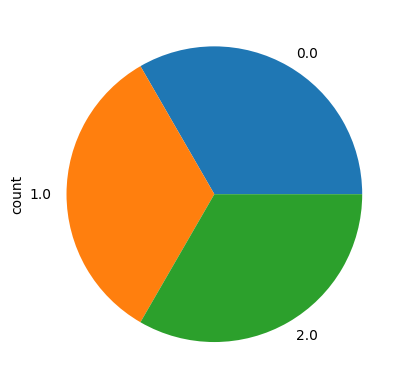

In [38]:
ovsmp_new_df.outcome.value_counts().plot.pie()

In [39]:
num_cols

['hospital_number',
 'rectal_temp',
 'pulse',
 'respiratory_rate',
 'nasogastric_reflux_ph',
 'packed_cell_volume',
 'total_protein',
 'abdomo_protein',
 'lesion_1',
 'lesion_2',
 'lesion_3']

In [40]:
num_cols_new = [i for i in num_cols if i not in ['lesion_1', 'lesion_2', 'lesion_3', 'hospital_number']]
num_cols_new.append('hospital_count')
num_cols_new

['rectal_temp',
 'pulse',
 'respiratory_rate',
 'nasogastric_reflux_ph',
 'packed_cell_volume',
 'total_protein',
 'abdomo_protein',
 'hospital_count']

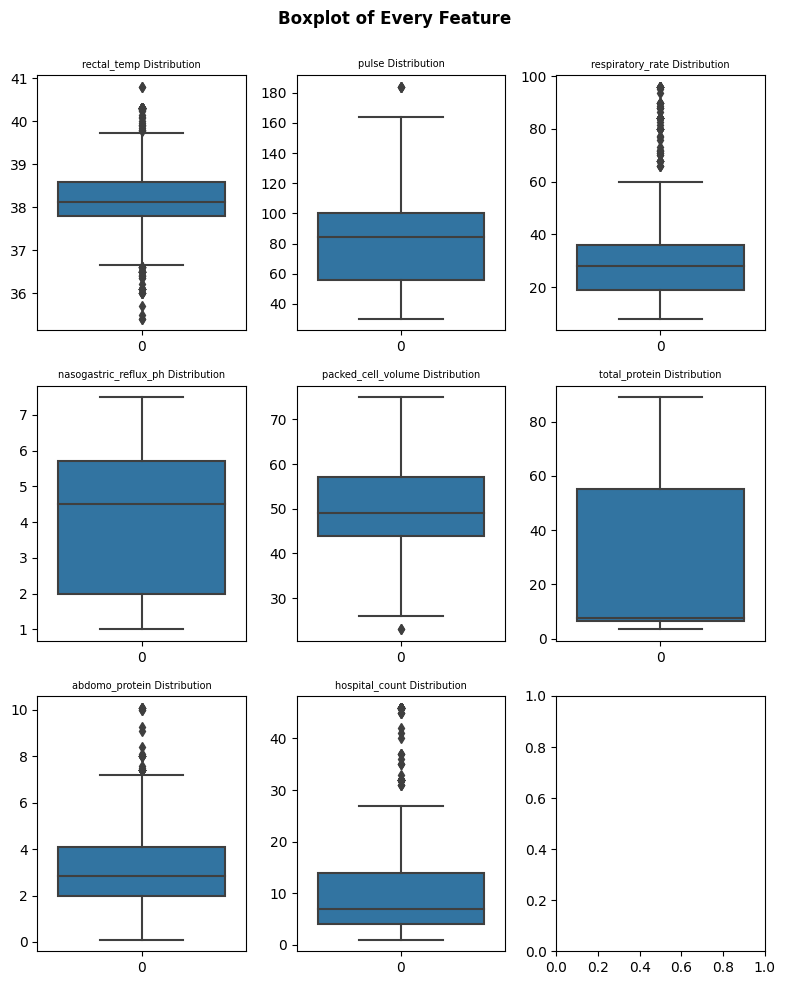

In [41]:
fig, ax = plt.subplots(3, 3, figsize = (8, 10))
ax = ax.flatten()

for i, column in enumerate(list(ovsmp_new_df[num_cols_new])):
    sns.boxplot(ovsmp_new_df[column], ax=ax[i])
    
    ax[i].set_title(f'{column} Distribution', size = 7)
    ax[i].set_xlabel(None)
    
fig.suptitle('Boxplot of Every Feature\n', fontweight = 'bold')
plt.tight_layout()

In [42]:
scaler = MinMaxScaler()
norm_df = ovsmp_new_df.copy()
norm_test_df = new_test_df.copy()
norm_df[num_cols_new] = scaler.fit_transform(ovsmp_new_df[num_cols_new])
norm_test_df[num_cols_new] = scaler.transform(new_test_df[num_cols_new])

In [43]:
norm_df

,surgery,age,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,cp_data,hospital_count,mucous_membrane_-1.0,mucous_membrane_0.0,mucous_membrane_1.0,mucous_membrane_2.0,mucous_membrane_3.0,mucous_membrane_4.0,mucous_membrane_5.0,outcome
0,1.000000,0.0,0.500000,0.662338,0.181818,2.000000,3.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.846154,2.000000,2.000000,0.653846,0.058480,2.000000,0.330000,1.000000,2209,0,0.000000,0.311111,0.0,0.000000,0.00000,1.000000,0.000000,0.000000,0.00000,0.0
1,1.000000,0.0,0.388889,0.376623,0.045455,2.000000,2.000000,1.000000,3.000000,0.000000,2.000000,0.000000,2.000000,0.153846,3.000000,2.000000,0.192308,0.707602,2.000000,0.190000,1.000000,2208,0,0.000000,0.177778,0.0,0.000000,0.00000,0.000000,0.000000,1.000000,0.00000,1.0
2,1.000000,0.0,0.537037,0.584416,0.227273,2.000000,3.000000,0.000000,4.000000,1.000000,2.000000,1.000000,0.000000,0.384615,-1.000000,3.000000,0.269231,0.033918,2.000000,0.330000,1.000000,5124,0,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,1.00000,2.0
3,1.000000,0.0,0.314815,0.272727,0.250000,3.000000,3.000000,1.000000,3.000000,1.000000,2.000000,1.000000,2.000000,0.153846,2.000000,2.000000,0.576923,0.040936,1.000000,0.380000,1.000000,2208,0,1.000000,0.022222,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,1.00000,2.0
4,0.000000,0.0,0.481481,0.142857,0.454545,1.000000,2.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.923077,1.000000,0.000000,0.461538,0.044444,1.000000,0.250000,0.000000,0,0,1.000000,0.111111,0.0,0.000000,0.00000,0.000000,1.000000,0.000000,0.00000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1708,0.000000,0.0,0.600591,0.206024,0.181818,2.000000,3.000000,0.178990,2.821010,0.821010,2.178990,-0.463029,1.821010,0.587848,2.642019,2.463029,0.257708,0.013471,1.178990,0.356731,1.000000,3113,0,0.821010,0.288889,0.0,0.000000,0.17899,0.000000,0.000000,0.000000,0.82101,1.0
1709,1.000000,0.0,0.420809,0.095694,0.074362,2.000000,0.092100,0.000000,0.907900,0.000000,1.364033,2.000000,1.635967,0.153846,0.907900,-1.000000,0.550692,0.793680,0.728067,0.190000,1.000000,3111,0,0.000000,0.266667,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,1.00000,1.0
1710,0.484351,0.0,0.409726,0.431823,0.318182,2.000000,3.000000,0.515649,1.968703,0.484351,1.515649,1.000000,2.000000,0.407704,3.000000,0.546946,0.747306,0.350223,2.000000,0.499389,1.000000,1400,0,0.515649,0.044444,0.0,0.000000,0.00000,0.515649,0.484351,0.000000,0.00000,1.0
1711,0.250346,0.0,0.518519,0.496542,0.363511,2.749654,2.749654,0.000000,1.000000,0.500691,2.499309,0.000000,2.000000,0.153846,-0.248963,-1.000000,0.745106,0.897633,1.000000,0.190000,0.250346,2209,1400,0.749654,0.244444,0.0,0.250346,0.00000,0.000000,0.000000,0.749654,0.00000,1.0


In [44]:
norm_test_df

,surgery,age,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,cp_data,hospital_count,mucous_membrane_-1.0,mucous_membrane_0.0,mucous_membrane_1.0,mucous_membrane_2.0,mucous_membrane_3.0,mucous_membrane_4.0,mucous_membrane_5.0
0,0.0,0.0,0.592593,0.064935,0.136364,1.0,2.0,0.0,3.0,1.0,1.0,0.0,0.0,0.923077,1.0,2.0,0.365385,0.046784,0.0,0.22,0.0,0,0,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.518519,0.532468,0.454545,2.0,3.0,1.0,1.0,1.0,2.0,1.0,0.0,0.384615,2.0,2.0,0.403846,0.029240,2.0,0.25,0.0,2208,0,1.0,0.466667,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.425926,0.233766,0.045455,2.0,2.0,0.0,3.0,1.0,1.0,1.0,0.0,0.307692,1.0,2.0,0.163462,0.029240,1.0,0.15,1.0,2205,0,1.0,0.066667,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.314815,0.376623,0.136364,2.0,3.0,0.0,1.0,0.0,3.0,1.0,2.0,0.153846,3.0,3.0,1.000000,0.906433,-1.0,0.09,1.0,1400,0,0.0,0.200000,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.537037,0.129870,0.045455,-1.0,2.0,0.0,3.0,0.0,1.0,1.0,0.0,0.307692,2.0,2.0,0.269231,0.038596,1.0,0.25,1.0,2208,0,1.0,0.066667,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
819,0.0,0.0,0.907407,0.545455,0.318182,2.0,3.0,1.0,1.0,1.0,2.0,-1.0,0.0,0.923077,1.0,3.0,0.653846,0.053801,2.0,0.44,1.0,3205,0,1.0,0.755556,0.0,0.0,0.0,0.0,1.0,0.0,0.0
820,1.0,0.0,0.333333,0.454545,0.136364,2.0,3.0,1.0,4.0,0.0,2.0,1.0,2.0,0.153846,3.0,2.0,0.519231,0.730994,2.0,0.19,1.0,2209,0,0.0,0.088889,0.0,0.0,0.0,0.0,0.0,1.0,0.0
821,1.0,0.0,0.703704,0.662338,0.045455,2.0,3.0,1.0,1.0,1.0,2.0,1.0,2.0,0.846154,2.0,-1.0,0.576923,0.047953,2.0,0.44,1.0,2205,0,0.0,0.022222,0.0,0.0,0.0,1.0,0.0,0.0,0.0
822,0.0,0.0,0.537037,0.155844,0.659091,1.0,2.0,0.0,3.0,1.0,0.0,1.0,0.0,0.923077,1.0,-1.0,0.500000,0.059649,0.0,0.49,0.0,3111,0,1.0,0.377778,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [45]:
X = norm_df.copy()
y = X.pop('outcome')

In [46]:
rf = RandomForestClassifier(random_state=41)

rf.fit(X, y)

result = permutation_importance(rf, X, y, scoring='f1_micro', n_repeats=4,random_state=21)

perm_imp = pd.DataFrame()
perm_imp['features'] = X.columns
perm_imp['importance'] = result.importances_mean
perm_imp.sort_values('importance', ascending=False)

,features,importance
17,total_protein,0.021454
3,pulse,0.011384
0,surgery,0.010654
19,abdomo_protein,0.009632
16,packed_cell_volume,0.007881
13,nasogastric_reflux_ph,0.007297
2,rectal_temp,0.005692
4,respiratory_rate,0.005692
14,rectal_exam_feces,0.005108
21,lesion_1,0.004524


# Modeling

In [47]:
kf = RepeatedKFold(n_splits = 5, random_state = 21, n_repeats = 4)

In [48]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

In [49]:
!pip install lazypredict

In [50]:
from lazypredict.Supervised import LazyClassifier

In [51]:
def lazy_cross_val_score(X, y, model, cv=kf):
    
    #initiate prediction arrays and score lists
    val_predictions = np.zeros((len(X)))
    train_scores, val_scores = [], []
    models=pd.DataFrame()
    
    #training model, predicting prognosis probability, and evaluating metrics
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        
        #define train set
        X_train = X.iloc[train_idx]
        y_train = y.iloc[train_idx]
        
        #define validation set
        X_val = X.iloc[val_idx]
        y_val = y.iloc[val_idx]
        
        #train model
        result, _ = model.fit(X_train, X_val, y_train, y_val)
        
        if models.empty:
            models = result
        else:
            models += result
        
    return models/cv.get_n_splits()

In [52]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models = lazy_cross_val_score(X, y, clf)

100%|██████████| 29/29 [00:08<00:00,  3.35it/s]


'tuple' object has no attribute '__name__'
Invalid Classifier(s)


100%|██████████| 29/29 [00:08<00:00,  3.40it/s]


'tuple' object has no attribute '__name__'
Invalid Classifier(s)


100%|██████████| 29/29 [00:08<00:00,  3.32it/s]


'tuple' object has no attribute '__name__'
Invalid Classifier(s)


100%|██████████| 29/29 [00:08<00:00,  3.35it/s]


'tuple' object has no attribute '__name__'
Invalid Classifier(s)


100%|██████████| 29/29 [00:09<00:00,  3.09it/s]


'tuple' object has no attribute '__name__'
Invalid Classifier(s)


100%|██████████| 29/29 [00:08<00:00,  3.45it/s]


'tuple' object has no attribute '__name__'
Invalid Classifier(s)


100%|██████████| 29/29 [00:08<00:00,  3.28it/s]


'tuple' object has no attribute '__name__'
Invalid Classifier(s)


100%|██████████| 29/29 [00:08<00:00,  3.28it/s]


'tuple' object has no attribute '__name__'
Invalid Classifier(s)


100%|██████████| 29/29 [00:08<00:00,  3.27it/s]


'tuple' object has no attribute '__name__'
Invalid Classifier(s)


100%|██████████| 29/29 [00:08<00:00,  3.30it/s]


'tuple' object has no attribute '__name__'
Invalid Classifier(s)


100%|██████████| 29/29 [00:08<00:00,  3.39it/s]


'tuple' object has no attribute '__name__'
Invalid Classifier(s)


100%|██████████| 29/29 [00:09<00:00,  3.03it/s]


'tuple' object has no attribute '__name__'
Invalid Classifier(s)


100%|██████████| 29/29 [00:08<00:00,  3.30it/s]


'tuple' object has no attribute '__name__'
Invalid Classifier(s)


100%|██████████| 29/29 [00:08<00:00,  3.31it/s]


'tuple' object has no attribute '__name__'
Invalid Classifier(s)


100%|██████████| 29/29 [00:08<00:00,  3.34it/s]


'tuple' object has no attribute '__name__'
Invalid Classifier(s)


100%|██████████| 29/29 [00:08<00:00,  3.28it/s]


'tuple' object has no attribute '__name__'
Invalid Classifier(s)


100%|██████████| 29/29 [00:08<00:00,  3.31it/s]


'tuple' object has no attribute '__name__'
Invalid Classifier(s)


100%|██████████| 29/29 [00:08<00:00,  3.41it/s]


'tuple' object has no attribute '__name__'
Invalid Classifier(s)


100%|██████████| 29/29 [00:09<00:00,  2.96it/s]


'tuple' object has no attribute '__name__'
Invalid Classifier(s)


100%|██████████| 29/29 [00:08<00:00,  3.41it/s]


In [53]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
XGBClassifier,0.79,0.79,NaN,0.79,1.27
LGBMClassifier,0.80,0.80,NaN,0.80,2.12
ExtraTreesClassifier,0.80,0.80,NaN,0.80,0.32
RandomForestClassifier,0.78,0.78,NaN,0.78,0.48
SVC,0.73,0.74,NaN,0.73,0.12
NuSVC,0.72,0.72,NaN,0.72,0.13
BaggingClassifier,0.74,0.74,NaN,0.74,0.15
LabelPropagation,0.75,0.75,NaN,0.75,0.31
LabelSpreading,0.75,0.75,NaN,0.75,0.37


In [54]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [55]:
import optuna

# LGBM

In [56]:
def objective_lgb(trial):
    params = {
        'objective': trial.suggest_categorical('objective', ['multiclass']),
        'metric': trial.suggest_categorical('metric', ['multi_logloss']),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 2000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
        "random_state" : trial.suggest_categorical('random_state', [42]),
    }
    model_lgb = LGBMClassifier(**params)
    model_lgb.fit(X_train, y_train)
    y_pred = model_lgb.predict(X_val)
    
    return f1_score(y_val,y_pred, average='micro')

In [57]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

study_lgb = optuna.create_study(direction='maximize')
study_lgb.optimize(objective_lgb, n_trials=50,show_progress_bar=True)
print('Best parameters', study_lgb.best_params)

  0%|          | 0/50 [00:00<?, ?it/s]

Best parameters {'objective': 'multiclass', 'metric': 'multi_logloss', 'max_depth': 4, 'min_child_samples': 6, 'learning_rate': 0.5152886091273678, 'n_estimators': 1671, 'min_child_weight': 2, 'subsample': 0.4516427576621343, 'colsample_bytree': 0.49272770100668034, 'reg_alpha': 0.1624232998964114, 'reg_lambda': 0.1319990682868854, 'random_state': 42}


In [58]:
lgb = LGBMClassifier(**study_lgb.best_params)
lgb.fit(X_train, y_train)
lgb_pred = lgb.predict(X_val)

print('F1-score: ', f1_score(y_val, lgb_pred, average='micro'))

F1-score:  0.7959183673469388


# XGBoost

In [59]:
def objective_xg(trial):
    params = {
        'booster': trial.suggest_categorical('booster', ['gbtree']),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),
        'n_estimators': trial.suggest_int('n_estimators', 300, 700),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 0.5),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'eval_metric':trial.suggest_categorical('eval_metric', ['mlogloss']),
    }
    model_xgb = XGBClassifier(**params)
    model_xgb.fit(X_train, y_train)
    y_pred = model_xgb.predict(X_val)
    
    return f1_score(y_val,y_pred, average='micro')

In [60]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xg, n_trials=50,show_progress_bar=True)
print('Best parameters', study_xgb.best_params)

  0%|          | 0/50 [00:00<?, ?it/s]

Best parameters {'booster': 'gbtree', 'max_depth': 8, 'learning_rate': 0.04208182115652097, 'n_estimators': 547, 'min_child_weight': 3, 'gamma': 0.0007000631569075436, 'subsample': 0.5023281001772502, 'colsample_bytree': 0.160841533771149, 'reg_alpha': 0.0008211270568222541, 'reg_lambda': 0.00024356112543451588, 'eval_metric': 'mlogloss'}


In [61]:
xgb = XGBClassifier(**study_xgb.best_params)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_val)

print('F1-score: ', f1_score(y_val, xgb_pred, average='micro'))

F1-score:  0.7988338192419825


# RandomForestClassifier

In [62]:
def objective_rfc(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 700),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 6),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 6),
        "random_state" : trial.suggest_categorical('random_state', [42]),
    }
    model_rfc = RandomForestClassifier(**params)
    model_rfc.fit(X_train, y_train)
    y_pred = model_rfc.predict(X_val)
    
    return f1_score(y_val,y_pred, average='micro')

In [63]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

study_rfc = optuna.create_study(direction='maximize')
study_rfc.optimize(objective_rfc, n_trials=50,show_progress_bar=True)
print('Best parameters', study_rfc.best_params)

  0%|          | 0/50 [00:00<?, ?it/s]

Best parameters {'n_estimators': 152, 'criterion': 'gini', 'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 2, 'random_state': 42}


In [64]:
rfc = RandomForestClassifier(**study_rfc.best_params)
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_val)

print('F1-score: ', f1_score(y_val, rfc_pred, average='micro'))

F1-score:  0.7434402332361516


# Submission

In [65]:
X_test = norm_test_df
preds = lgb.predict(X_test)
submission_df = pd.DataFrame()
submission_df['id'] = test_ids
submission_df['outcome'] = preds
submission_df['outcome'] = submission_df['outcome'].replace({0:'died', 1:'euthanized', 2:'lived'})
submission_df

,id,outcome
0,1235,lived
1,1236,lived
2,1237,lived
3,1238,euthanized
4,1239,lived
...,...,...
819,2054,died
820,2055,euthanized
821,2056,died
822,2057,lived


In [66]:
submission_df.to_csv('submission.csv', index=False)